In [45]:
import numpy as np
import matplotlib.pyplot as plt
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace, mass, laplace
from skfem.helpers import grad, dot, laplacian
from skfem.utils import enforce
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

In [126]:
# Definir dominio y mallado
nx, ny = 8, 8
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [127]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = ElementTriP1()
basis_u = Basis(mesh, element, intorder=4)

In [128]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Ensamblaje de matrices
A =  asm(laplace, basis_u)               
M =  asm(mass_matrix, basis_u)    


In [130]:
# Fronteras de la velocidad
x_boundary = np.zeros(basis_u.N)

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# # Elementos con condiciones de Dirichlet para la velocidad
# # Impares y, pares x
# y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
# y_right  = basis_u.doflocs[1, dofs_right[1::2]]

# x_left   = basis_u.doflocs[0, dofs_left[::2]]  
# x_right  = basis_u.doflocs[0, dofs_right[::2]]

# x_top    = basis_u.doflocs[0, dofs_top[::2]]
# x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

# y_top    = basis_u.doflocs[1, dofs_top[1::2]]
# y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


# x_boundary[dofs_left[::2]]    =  0.0  # componente x
# x_boundary[dofs_left[1::2]]   =  0.0  # componente y

# x_boundary[dofs_right[::2]]   =  0.0  # componente x
# x_boundary[dofs_right[1::2]]  =  0.0  # componente y

# x_boundary[dofs_top[::2]]     =  0.0  # componente x
# x_boundary[dofs_top[1::2]]    =  0.0  # componente y

# x_boundary[dofs_bottom[::2]]  =  0.0  # componente x
# x_boundary[dofs_bottom[1::2]] =  0.0  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

A_f = enforce(A, D=dofs_u_boundary)

In [ ]:
AII, xI, I   = condense(A, D=dofs_u_boundary)
MII, xIM, IM = condense(M, D=dofs_u_boundary)

In [171]:
k_eigs = 5
eigenvalues, eigenvectors = eigsh(A=AII, M=MII, k=k_eigs, which='SM',
                                      tol=1e-12, maxiter=10000)

<Axes: >

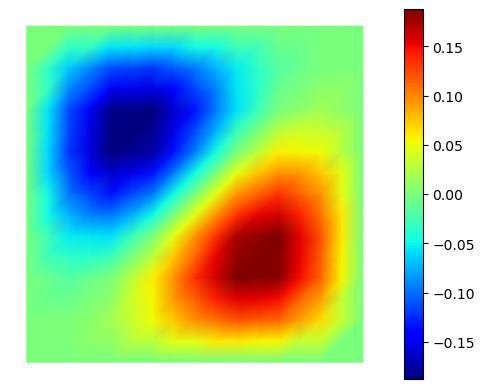

In [172]:
i = 1
u_sol    = np.zeros(basis_u.N)
u_sol[I] = eigenvectors[:, i]

# Componente u de la velocidad
basis_u.plot(u_sol, shading='gouraud', colorbar=True)


In [141]:
# Definir dominio y mallado
nx, ny = 8, 8
mesh_poisson = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

mesh_poisson = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [147]:
basis_u_poisson = Basis(mesh_poisson, ElementTriP1(), intorder=4)

In [ ]:
# Ensamblaje de matrices
A = asm(laplace, basis_u_poisson)               

@LinearForm
def rhs_u(v, w):
    x, y = w.x
    return 2*np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y) * v

F = asm(rhs_u, basis_u_poisson) 

In [158]:
dofs_left     = basis_u_poisson.get_dofs('left').all()
dofs_right    = basis_u_poisson.get_dofs('right').all()
dofs_top      = basis_u_poisson.get_dofs('top').all()
dofs_bottom   = basis_u_poisson.get_dofs('bottom').all()

D_all = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
]) 

In [166]:
AII, bII, xI, I   = condense(A, b=F, D=D_all)

In [164]:
sol_II = solve(A=AII, b=bII)

sol_full = np.zeros(basis_u_poisson.N)
sol_full[I] = sol_II

<Axes: >

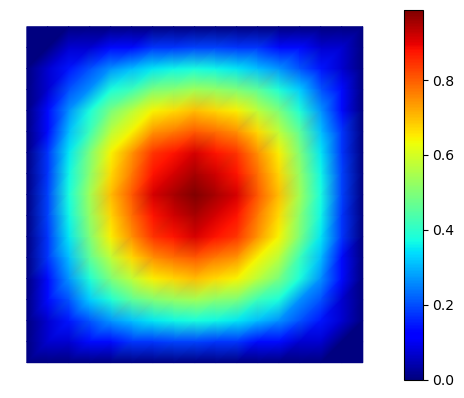

In [165]:
basis_u_poisson.plot(sol_full, shading='gouraud', colorbar=True)